# EVOLUTIONARY CITY MODEL
## An Agent Based Model
*Put this notebook in the same folder where the virtualenv is created to avoid dependency conflicts.*

### Model Description 

* The payoff for Agent $i$ is of the form $$U_i = E_{C_{i,work}}r_{i}n_{i,work}  - cn_{i,live}^2$$, 
    - $E_{C_{i,work}}$ is Shannon Entropy of the city where agent $i$ works. We use the following discretized form with agents divided into $g$ number of groups based on their ability levels. $$E = -\sum_{i=1}^{i=g}p_i\log_ep_i, \text{where } p_i=\frac{\text{No. of working agents of Type i in a city/cell}}{\text{Total no. of working agents in the city/cell}}$$ 
    - $r_i$ is the ability of agent $i$ , where $r_i\in(0,1)$ and drawn from a uniform distribution.
    - The ability level domain is divided into $g$ equal intervals with size $\frac{1}{g}$ and agents are classified as $\text{Type }1$ if $r\in(0,\frac{1}{g})$, $\text{Type }2$ if $r\in(\frac{1}{g},\frac{2}{g})$ and so on. So for $g=4$, an agent with $r=0.66$ is a $\text{Type }3$ agent as $0.66\in(0.5,0.75)$. 
    - For $r_i > 0.8$ agents have the choice to work in one city and live in another. 
    - $n_{i,work}$ is the number of agents in the city where agent $i$ works and $n_{i,live}$ is the number of agents in the city where agent $i$ lives. 
    - $c$ is a constant.

    
* The model space is **20x20** size Multigrid allowing multiple agents to be present in a cell/city.

* Agents use bounded rationality. Each agent is initialized with attribute **radius** which defines the maximum number of cells it considers while making a move. The radius is defined in a way s.t higher ability agents are more mobile than lower ability agents. This is done by having the radius drawn from a scaled beta distribution $\beta(a,b)$ with shape parameters $a=r\text{ , }b=1-r$. So for higher $r$ the distribution is skewed to right meaning a greater chance of having larger values and vice-versa. The scaling factor is 10, which is half of our grid size. The distribution of radius is illustrated below.

* The model takes the total number of agents in all cities *'$N$'*, negative coefficient *'$c$'* and number of skill groups 
'$g$'* as inputs. The model also takes agent activation schedule as an input to test Random and Simulataneous activation of agents at each step. Pass **activation = 0** for Random Activation and **activation = 1** for Simultaneous Activation.

* At each model step, the agents calculate the payoff before moving into one of their neighboring cells. If the utiltiy is higher than the agent's current cell, it makes a move otherwise stays put in his current cell. For higher ability agents, they have a chice to work from home.

### Model classes and functions

* All agents are instances of class **Habitant** and the city model is an instance of class **City_Model**. 

* **shannon_E** is a global function that returns the entropy of a cell. 


* There are 5 model level data collectors-
  - **city_sizes** -  returns an array corresponding to model grid containing the number of agents in each cell.   
  - **city_ranks** - returns a list of tuples. Each tuple contains the cell coordinates and its rank.
  - **model_entropy** - returns a list of lists. Each sublist contains the cell coordinates and its entropy.
  - **model_utility** - returns utility of the entire model which is simply sum of individual agent utilities.
  - **skill_levels** - returns a sorted dictionary with agent types as values and city sizes as keys. Cities of same sizes are merged. 


### Model outputs and sensitvity analysis
* We have 3 model outputs which are used to carry out senstivity analysis-
  - **model_rsquare** - This is the rsquare coefficient of the linear regression of the city size - rank plot. 
  - **model_beta** - This the slope of the linear regression of the city size -rank plot.
  - **mean_entropy** - This is the mean entropy of all the cities/cells.

In [38]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import random
import numpy as np
import math
import time
import collections
import operator
from IPython.display import clear_output 
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
import scipy.stats as st
import statistics
from scipy.stats import norm
from itertools import combinations, permutations

### Helper functions

In [2]:
'''Function to calculate Entropies'''
def shanon_E(type_list):
    occurences = collections.Counter(type_list)
    n = sum(occurences.values())
    entropy = 0
    for i in occurences:
        p = occurences[i]/n
        entropy += -p * math.log(p)
        
    return entropy

def normalize(data, sizes_list):
    """
    Normalize values in data by sizes_list
    """
    for i in range(len(data)):
        if sizes_list[i] != 0:
            d = data[i] / sizes_list[i]
        else:
            d = data[i-1]
        data[i] = d
    
    return data

def make_median_list(new_data, sizes_list):
    '''
    Return a median list
    '''
    median_list = []
    for i, _ in enumerate(new_data):
        for _ in range(int(new_data[i])):
            median_list.append(sizes_list[i])

    return median_list

'''
Function returns coefficients from linear regression 
'''
def regress(ranklist):
    n = len(ranklist)
    ranks = range(1, n+1)                        # y-axis: log(the ranks)
    pops = [pops for (coords, pops) in ranklist] # x-axis: log(the poplution size)
    ## Remove 0's to avoid log(0)
    if 0 in pops:
        idx = pops.index(0)
        pops = pops[:idx]
        ranks = ranks[:idx]
    else:
        idx = len(pops)-1
        pops = pops[:idx]
        ranks = ranks[:idx]
    ## regression
    slope, intercept, r_value, p_value, std_err = st.linregress(np.log(np.array(pops)), np.log(np.array(ranks)))
    return slope, intercept, r_value, p_value, std_err

### Distribution of agent vision for different skill levels($r$) and fixed model radius of 10

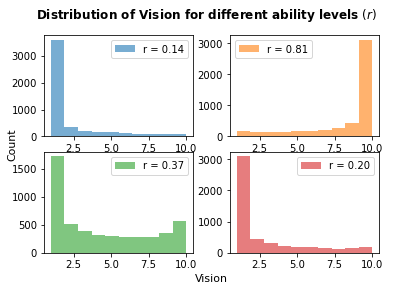

In [4]:
ability_list = [np.random.uniform() for x in range(4)]
vision_list = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for r in ability_list:
    temp_list = []
    for j in range(5000):
        temp_list.append(math.ceil(np.random.beta(r,(1-r)) * 10))
    vision_list.append(temp_list)
    
fig ,axs = plt.subplots(2,2) 
axs = axs.ravel()
for i ,r in enumerate(ability_list):
    axs[i].hist(vision_list[i],alpha=0.6,label='r = {:.2f}'.format(r), color=colors[i])
    axs[i].legend(loc='best')
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vision",fontsize=11)
plt.ylabel("Count",fontsize=11)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
fig.suptitle(r'Distribution of Vision for different ability levels $(r)$',fontweight='bold',fontsize=12)

plt.show() 

### Model and Agent Classes with model reporters

In [34]:

'''Model Reporters'''
def city_sizes(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

def city_ranks(model):   
    ranklist = []
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        ranklist.append(((x,y),len(cell_content)))
        
    ranklist.sort(key=operator.itemgetter(1), reverse=True)
    return ranklist

def model_rsquare(model):
    return regress(city_ranks(model))[2] **2

def model_beta(model):
    return regress(city_ranks(model))[0]

def skill_levels(model):
        skill_dict = {}
        for cell in model.grid.coord_iter():
            cell_content, x, y = cell
            key = "Citysize {}".format(len(cell_content))
            if key in skill_dict:
                for agent in cell_content:
                    skill_dict[key].append(agent.type)
            else:
                type_list = []
                for agent in cell_content:
                    type_list.append(agent.type)
                skill_dict[key] = type_list

        return collections.OrderedDict(sorted(skill_dict.items(), key=lambda x: chr(int(x[0][9:])), reverse = True))
        
def model_utility(model):
    agent_utility = [agent.utility(agent.pos) for agent in model.schedule.agents]
    return sum(agent_utility)
    

def model_entropy(model):
    entropy_list = []
    for cell in model.grid.coord_iter():
        cell_agents, x, y = cell
        type_list = []
        if len(cell_agents) == 0:
            entropy_list.append([(x,y), 0])
            
        else:
            for agent in cell_agents:
                type_list.append(agent.type)

            entropy_list.append([(x,y), shanon_E(type_list)])

    return entropy_list

def mean_entropy(model):
    cell_entropy_list = model_entropy(model)
    entropy = [] 
    for i in cell_entropy_list:
        entropy.append(i[1])
        
    return np.mean(entropy)
 
'''Agent Class'''
class Habitant(Agent):
    
    def __init__(self, unique_id, model, agent_ability):
        super().__init__(unique_id, model)
        self.r = agent_ability
        self.vision = math.ceil(np.random.beta(self.r,(1-self.r)) * self.model.radius)    # fixed grid size of 20 
        self.type = None
        self.work_coord = self.pos

        for i in range(len(self.model.skill_levels)):
            if self.model.skill_levels[i]< self.r <= self.model.skill_levels[i+1]:
                self.type = "Type {}".format(i+1)
           
        self.steps = 0
        self.no_moves = 0
    '''
    Normal utility 
    '''   
    def utility(self, coord):           
        tot_agents = self.model.grid.get_cell_list_contents(coord)
        n_liv = len(tot_agents)
        agent_type_list = []
        for agent in self.model.schedule.agents:
            if agent.work_coord == coord:
                agent_type_list.append(agent.type)
                
        n_work = len(agent_type_list)        
        #agent_type_list = [agent.type for agent in tot_agents]
                
        # check utility for current cell or neighbouring cell        
        if coord != self.pos:
            # +1 term if the agent considers neighbouring cell
            agent_type_list.append(self.type)
            return (shanon_E(agent_type_list) * self.r * (n_work + 1))  - (self.model.c * (n_liv + 1)**2)  
        else:
            # utility stays the same if agent stays put in current cell

            return (shanon_E(agent_type_list) * self.r * n_work) - (self.model.c * n_liv**2)     
    '''
    Work from home utility
    '''    
    def wfh(self, coords):
        
        '''
        coord1 -> working city , coord2 ->living city 
        '''
        coord1 ,coord2 = coords   
        agents_liv = self.model.grid.get_cell_list_contents(coord2)
        n_liv = len(agents_liv)
        agent_type_list = []
        for agent in self.model.schedule.agents:
            if agent.work_coord == coord1:
                agent_type_list.append(agent.type)
        n_work = len(agent_type_list)

        if coord1 == self.work_coord and coord2 != self.pos:

            return (shanon_E(agent_type_list) * self.r * n_work)  - (self.model.c * (n_liv + 1)**2)

        elif coord1 != self.work_coord and coord2 == self.pos:

            agent_type_list.append(self.type)
            return (shanon_E(agent_type_list) * self.r * (n_work + 1))  - (self.model.c * n_liv **2)

        elif coord1 == self.work_coord and coord2 == self.pos:

            return (shanon_E(agent_type_list) * self.r * n_work) - (self.model.c * n_liv**2) 

        else:

            agent_type_list.append(self.type)
            return (shanon_E(agent_type_list) * self.r * (n_work + 1))  - (self.model.c * (n_liv + 1)**2)
        
    
    def move(self):
        if self.r < 0.8:
            neighbor_cell_pos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False,radius=self.vision)
            cell_dict = {}     # define a cell dictionary = {keys = (coordinates): values = utility}
            max_pos = None

            for n in neighbor_cell_pos:     
                cell_dict[n] = self.utility(n)

                MaxValue = max(cell_dict.items(), key=lambda x: x[1])    
                # get the coordinates of maximum utility 
                listcoords = []
                # Iterate over all the items in dictionary to find keys with max value
                for coord, util in cell_dict.items():
                    if util == MaxValue[1]:
                        listcoords.append(coord)

                max_pos = random.choice(listcoords)  # make a random choice if multiple cells have same utility
                # move only when moving gives a utility benefit
                if self.utility(max_pos) > self.utility(self.pos):
                    self.model.grid.move_agent(self, max_pos)

                else: self.no_moves += 1

            self.work_coord = max_pos

        else:
            neighbor_cell_pos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True, radius=self.vision)
            cell_combos = list(permutations(neighbor_cell_pos,2))
            cell_combos.append((self.pos, self.pos))  # agent may consider leaving and working in same city
            cell_dict = {}
            max_pos = None

            for n in cell_combos:
                cell_dict[n] = self.wfh(n)

                MaxValue = max(cell_dict.items(), key=lambda x: x[1])    
                # get the coordinates of maximum utility 
                listcoords = []
                # Iterate over all the items in dictionary to find keys with max value
                for coord, util in cell_dict.items():
                    if util == MaxValue[1]:
                        listcoords.append(coord)

                max_pos = random.choice(listcoords)  # make a random choice if multiple cells have same utility

                # move only when moving gives a utility benefit
                if max_pos[1] != self.pos:
                    self.model.grid.move_agent(self, max_pos[1])   #lives in 2nd coord

                else: self.no_moves += 1

            self.work_coord = max_pos[0]    #works in 1st coord
                          
    def step(self):
        # for RandomActivation
        if self.model.act == 0:
            self.move()
        elif self.model.act == 1:
            self.steps += 1
    
    # for SimultaneousActivation
    def advance(self):    
        self.move()

'''Model Class'''
class City_Model(Model):
    """Note the default model parameters"""
    def __init__(self, height = 20, width = 20, N = 1000, neg_coff = 0.1, activation = 0, num_groups=3, radius_coff=0.5):
        assert activation in [0,1], 'Activation should be "0 or 1". O for Random , 1 for Simultaneous'
        self.height = height
        self.width = width
        self.num_agents = N
        self.c = neg_coff
        self.act = activation
        self.g = num_groups
        self.skill_levels = np.linspace(0, 1, self.g+1).tolist()
        self.radius = radius_coff
        
        if self.act == 0:
            self.schedule = RandomActivation(self)
        elif self.act == 1:
            self.schedule = SimultaneousActivation(self) 
        
        self.grid = MultiGrid(width, height, True)
        self.running = True
        #Create agents with some ability
        for i in range(self.num_agents):
            agent_ability = np.random.uniform()
            agent = Habitant(i, self, agent_ability)
            self.schedule.add(agent)
    
            # Add the agent to random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))
            
        self.datacollector = DataCollector(model_reporters = {"City_sizes": city_sizes,"Ranks": city_ranks,
                                                             "Utility": model_utility,"Skill_dist": skill_levels,
                                                              "Rsquare":model_rsquare,"Beta":model_beta,
                                                              "Mean_entropy":mean_entropy}) 
     
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self) 
        self.schedule.step()

### Define a function that plots Citysizes vs Agent-types 

In [35]:
def bar_plot(num_groups, a_dict , total_width=0.8, single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.
        
    model_instance : an instance of City_Model

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the Citysizes and 
        the values are a list of counts in each skill-group. 

        Example:
        dict = {
            "Citysize 20":[1,2,3],
            "Citysize 15":[4,5,6],
            "Citysize 10":[7,8,9],
        }
        Citysize 15 has Type 1 = 4, Type 2 = 5 , Type 3 = 6 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    """
    default_counter = collections.Counter()
    data = {}
    for i in range(num_groups):
        default_counter["Type {}".format(i+1)] = 0 
    for i in a_dict:
        A = collections.Counter(a_dict[i])
        A.update(default_counter)
        data[i] =  list(collections.OrderedDict(sorted(A.items())).values())
        
    # remove citysizes with 0 population    
    #data.pop("Citysize 0")
    
    colors = ['xkcd:bright purple','xkcd:green','xkcd:blue', 'xkcd:pink','xkcd:brown','xkcd:red','xkcd:light blue',
            'xkcd:yellow','xkcd:grey','xkcd:lavender','xkcd:tan','xkcd:black','xkcd:lime','xkcd:aqua','xkcd:orange',
            'xkcd:peach','xkcd:fuchsia','xkcd:butter', 'xkcd:green yellow', 'xkcd:light seafoam green','xkcd:light rose',
            'xkcd:bright aqua','xkcd:light olive','xkcd:greyish blue','xkcd:pinkish','xkcd:light turquoise','xkcd:goldenrod',
            'xkcd:cobalt blue','xkcd:dusty blue','xkcd:ice','xkcd:light khaki','xkcd:fresh green','xkcd:cloudy blue',
            'xkcd:leather','xkcd:muted pink','xkcd:light peach','xkcd:hospital green','xkcd:greyish pink','xkcd:perrywinkle']
    
    # Get maximum agents in a city
    max_city_size = 0
    for key in data.keys():
        size = int(key.split()[1])
        if size > max_city_size:
            max_city_size = size
    
    # List of city sizes found in the model
    sizes_list = np.linspace(1, max_city_size, max_city_size)
    
    # 
    number_of_types = len(data["Citysize 0"])
    counter = 0
    new_data = np.zeros((number_of_types, max_city_size))
    for key, values in data.items():
        city_size = int(key.split()[1])
        for value in values:
            current_type = counter % number_of_types
            new_data[current_type][city_size - 1] = value
            counter += 1

   # print(f"rows in new_data = {len(new_data)}")
   # print(f"columns in new_data = {len(new_data[0])}")
   # print("#################################")
   # print(new_data)
    
    means = []
    
    total_list = np.zeros(len(new_data[0]))
    for i in range(len(new_data)):
        total_list = list(map(lambda x, y: x + y, total_list, new_data[i]))
    # Plots
    fig, ax = plt.subplots(number_of_types)
    fig.text(0.5, 0.04, 'City size', ha='center')
    fig.text(0.04, 0.5, '# of Agents (% of city population)', va='center', rotation='vertical')
    for i in range(number_of_types):
        j = 0
        new_list = make_median_list(new_data[i], sizes_list)
        data = np.zeros(max_city_size)
        #while i >= j:
        #    data += new_data[i]
        #    print(f"first element of data = {data[1]} and j = {j}")
        #    j += 1
        values = []
        total_agents = sum(new_data[i])
        for idx in range(len(new_data[i])):
            value = new_data[i][idx] * sizes_list[idx]
            values.append(value)

        mean = sum(values) / sum(new_data[i])
        errors = [(mean - x)**2 for x in values]
        var = sum(errors) / sum(new_data[i])
        print(f"Agent type {i}:\nmean = {round(mean, 2)} and variance = {round(var, 2)}")
        norm_data = normalize(new_data[i], total_list)
    
        ax[i].plot(sizes_list, norm_data, label=f"Type {i+1}", color=colors[i])
        ax[i].set_ylim(0, 1.1)
        ax[i].set_xlim(-max(sizes_list)/100, max(sizes_list))
        ax[i].legend(fontsize=8)
        
        median = statistics.median(new_list)
        median_list = [median, median, median]
        ax[i].plot([median, median, median], np.linspace(0,1, 3), dashes=[1, 0.8], color=colors[i])
    
    plt.show()

### Run a test model and collect data

In [36]:
N=1000
num_groups=5
test_model = City_Model(N = N, num_groups=num_groups,activation = 0) 
STEPS = 20
for i in range(STEPS): # run model for some steps
    print(f"Step {i}")
    test_model.step()
    
city_evolution = test_model.datacollector.get_model_vars_dataframe()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19


Agent type 0:
mean = 2.48 and variance = 240.97
Agent type 1:
mean = 4.11 and variance = 491.88
Agent type 2:
mean = 5.22 and variance = 831.45
Agent type 3:
mean = 5.45 and variance = 952.45
Agent type 4:
mean = 1.78 and variance = 422.27


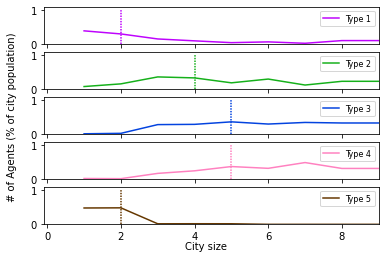

In [39]:
##collect data at last step 
plot_dict = city_evolution["Skill_dist"].iloc[STEPS-1]
bar_plot(num_groups, a_dict= plot_dict)

### Visualize city sizes at each step

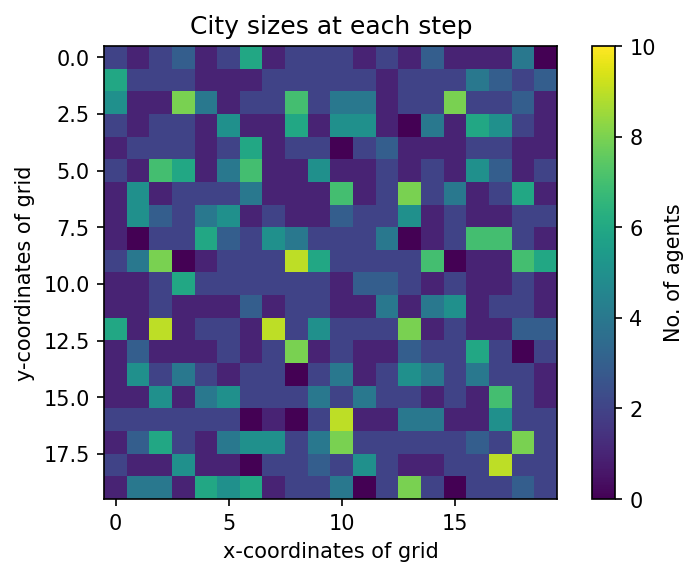

In [40]:
%matplotlib inline
## Plot city sizes over time. 
MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

for i in range(STEPS):
    fig = plt.figure(dpi=150)
    plt.imshow(city_evolution["City_sizes"][i])
    plt.title("City sizes at each step")
    plt.xlabel("x-coordinates of grid")
    plt.ylabel("y-coordinates of grid")
    plt.colorbar(label="No. of agents")
    plt.clim(MIN, MAX)
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

In [ ]:
'''
Create animation and save
'''
%matplotlib notebook

MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

fig = plt.figure(dpi=400)
ax = plt.axes()

a=city_evolution["City_sizes"]
im=plt.imshow(a[0])


# animation function.  
def animate(i):

    im.set_array(a[i])
    im.set_clim(MIN, MAX)
    return [im]

plt.title("City sizes at each step")
plt.xlabel("x-coordinates of grid")
plt.ylabel("y-coordinates of grid")
plt.colorbar(label="No. of agents")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


anim = animation.FuncAnimation(fig, animate, frames=STEPS, interval=500,blit=True)

#Save the animation
'''
f = r"C:\...Set a PATH....\citysize-vid.mp4" 
writervideo = animation.FFMpegWriter(fps=1) 
anim.save(f, writer=writervideo)'''

### Plot overall model utitlites at each step

<AxesSubplot:title={'center':'Model Utilities at each step'}, xlabel='steps', ylabel='utility'>

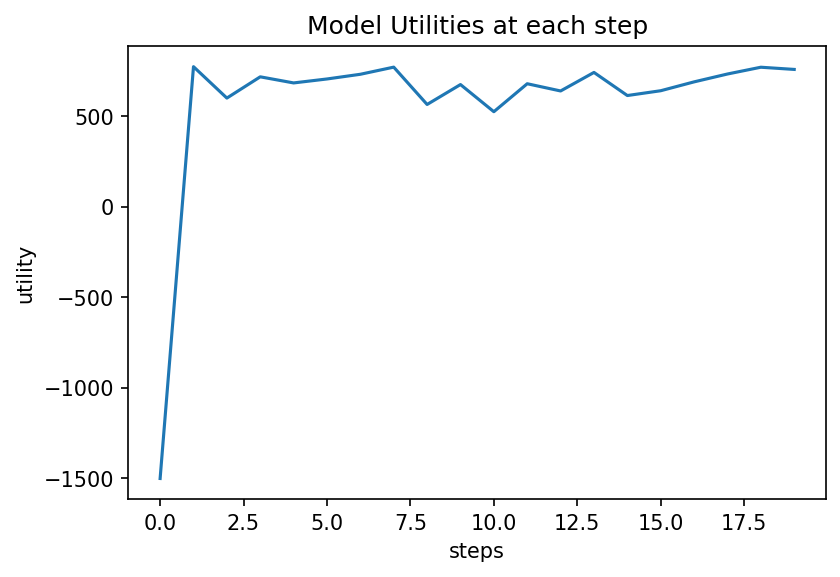

In [41]:
fig = plt.figure(dpi=150)
city_evolution["Utility"].plot(xlabel="steps", ylabel="utility",title="Model Utilities at each step")

### Visualize city rank - size distribution of cities(cells) at each step

In [42]:
for i in range(STEPS):
    ranklist = city_evolution.iloc[i]["Ranks"]
    n = len(ranklist)
    ranks = range(1, n+1)                        # y-axis: log(the ranks)
    pops = [pops for (coords, pops) in ranklist] # x-axis: log(the poplution size)
    ## Remove 0's to avoid log(0)
    if 0 in pops:
        idx = pops.index(0)
        pops = pops[:idx]
        ranks = ranks[:idx]
    else:
        idx = len(pops)-1
        pops = pops[:idx]
        ranks = ranks[:idx]
    ## regression interval
    x = np.linspace(np.log(pops[idx-1]),np.log(pops[0]),3)
    ## regression
    slope, intercept, r_value, p_value, std_err = st.linregress(np.log(np.array(pops)), np.log(np.array(ranks)))
    ## 'scatter' plot and regression line
    fig = plt.figure(dpi=150)
    plt.plot(np.log(pops), np.log(ranks), '.',label='city sizes')
    plt.plot(x,slope*x+intercept)
    ## plot specifics
    plt.title('slope: {}. R2: {}'.format(slope,r_value**2))
    plt.xlabel('log(population size)')
    plt.ylabel('log(ranks)')
    plt.legend(loc='lower left')
    plt.show()
    
    time.sleep(0.1)
    clear_output(wait=True)
    
print(slope,r_value**2)

-1.3995594007737309 0.8474819695926759


### See entropy distribution of cities at the end of each Model run. 

**Visualise entropy distribution at each step**

In [ ]:
for i in range(5):                       # iterate the model 5 times
    model = city_model()                 # default params used
    for j in range(STEPS):                  # run each model for some steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[STEPS-1]["Entropy"]:   # check the entropies at end of model run
        eList.append(j[1])   
    intv95 = st.norm.interval(alpha=0.95, loc=np.mean(eList), scale=st.sem(eList))
    # Plot the histogram.
    fig = plt.figure(dpi=150)
    plt.hist(eList, bins= "auto", density=True,color='firebrick',alpha=0.6, 
             label="Distribution of entropies at end of model run {}".format(i+1))
    plt.axvline(x=np.mean(eList), color='k', linestyle='dashdot', label="Mean")
    plt.axvline(x=intv95[0],color='yellow',linestyle='--',linewidth=0.8,label='Lower bound of 95% Confidence Interval')
    plt.axvline(x=intv95[1],color='blue',linestyle='--',linewidth=0.8,label='Upper bound of 95% Confidence Interval')
    plt.xlabel('Entropy of cities')
    plt.ylabel('Frequency of occurence')
    plt.title("Distribution of cell entropies at the end of each Model iteration",pad=20)
    plt.legend(loc='best', shadow=True, prop={'size': 7}, facecolor="silver")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Parameter sweep for $num\text{_}groups$ in $[3,4,5,6,7,8,9,10]$ using 10 model iterations and 20 steps for each model run. Random Activation

In [ ]:
fixed_params = {"N": 1000,"width": 20,
               "height": 20, "neg_coff": 10**-3, "activation": 0}
variable_params = {"num_groups": [3, 4, 5, 6, 7, 8, 9, 10]}

mod_iter = 10
mod_steps = 20
batch_run1 = BatchRunner(City_Model,
                        variable_params,
                        fixed_params,
                        iterations = mod_iter,
                        max_steps = mod_steps,
                        model_reporters={"Entropy": model_entropy, "Ranks": city_ranks, "Sizes": city_sizes, 
                                         "Skill-levels":skill_levels, "Utility": model_utility})
batch_run1.run_all()

In [ ]:
run_data = batch_run1.get_model_vars_dataframe()
run_data

### $R^2$ value tests

In [ ]:
   
r_dict = {"g3":[],"g4":[],"g5":[],"g6":[],"g7":[], "g8":[],"g9":[],"g10":[]}

for i in range(len(variable_params["num_groups"])*mod_iter):
    if int(i/10) == 0:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g3"].append(r_value**2)
    elif int(i/10) == 1:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g4"].append(r_value**2)
    elif int(i/10) == 2:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g5"].append(r_value**2)   
    elif int(i/10) == 3:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g6"].append(r_value**2)
    elif int(i/10) == 4:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g7"].append(r_value**2)
    elif int(i/10) == 5:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g8"].append(r_value**2)
    elif int(i/10) == 6:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g9"].append(r_value**2)
    elif int(i/10) == 7:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g10"].append(r_value**2)
    

fig, ax = plt.subplots(dpi=200)
ax.violinplot([r_dict["g3"],r_dict["g4"],r_dict["g5"],r_dict["g6"],r_dict["g7"],r_dict["g8"],
              r_dict["g9"],r_dict["g10"]],showmeans=True)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(['G3','G4','G5','G6','G7','G8','G9','G10'])
ax.set_xlim(0.25, 8.75)
ax.set_xlabel(r'Different group sizes, $g$',fontsize=10)
ax.set_ylabel(r'$R^2 values$',fontsize=10)
ax.grid()


r_dict["g3"] = [np.mean(r_dict["g3"]), np.var(r_dict["g3"])]   
r_dict["g4"] = [np.mean(r_dict["g4"]), np.var(r_dict["g4"])]  
r_dict["g5"] = [np.mean(r_dict["g5"]), np.var(r_dict["g5"])]  
r_dict["g6"] = [np.mean(r_dict["g6"]), np.var(r_dict["g6"])]  
r_dict["g7"] = [np.mean(r_dict["g7"]), np.var(r_dict["g7"])]
r_dict["g8"] = [np.mean(r_dict["g8"]), np.var(r_dict["g8"])]
r_dict["g9"] = [np.mean(r_dict["g9"]), np.var(r_dict["g9"])]
r_dict["g10"] = [np.mean(r_dict["g10"]), np.var(r_dict["g10"])]
print(r"mean of $r^2$ values and variances", r_dict)

### $\beta$ value tests

In [ ]:
beta_dict = {"g3":[],"g4":[],"g5":[],"g6":[],"g7":[], "g8":[],"g9":[],"g10":[]}

for i in range(len(variable_params["num_groups"])*mod_iter):
    if int(i/10) == 0:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g3"].append(slope)
    elif int(i/10) == 1:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g4"].append(slope)
    elif int(i/10) == 2:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g5"].append(slope)   
    elif int(i/10) == 3:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g6"].append(slope)
    elif int(i/10) == 4:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g7"].append(slope)
    elif int(i/10) == 5:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g8"].append(slope)
    elif int(i/10) == 6:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g9"].append(slope)
    elif int(i/10) == 7:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g10"].append(slope)

fig, ax = plt.subplots(dpi=200)
ax.violinplot([beta_dict["g3"],beta_dict["g4"],beta_dict["g5"],beta_dict["g6"],beta_dict["g7"],beta_dict["g8"],
              beta_dict["g9"],beta_dict["g10"]],showmeans=True)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(['G3','G4','G5','G6','G7','G8','G9','G10'])
ax.set_xlim(0.25, 8.75)
ax.set_xlabel(r'Different group sizes, $g$',fontsize=10)
ax.set_ylabel(r'$\beta$ values',fontsize=10)
ax.grid()


beta_dict["g3"] = [np.mean(r_dict["g3"]), np.var(r_dict["g3"])]   
beta_dict["g4"] = [np.mean(r_dict["g4"]), np.var(r_dict["g4"])]  
beta_dict["g5"] = [np.mean(r_dict["g5"]), np.var(r_dict["g5"])]  
beta_dict["g6"] = [np.mean(r_dict["g6"]), np.var(r_dict["g6"])]  
beta_dict["g7"] = [np.mean(r_dict["g7"]), np.var(r_dict["g7"])]
beta_dict["g8"] = [np.mean(r_dict["g8"]), np.var(r_dict["g8"])]
beta_dict["g9"] = [np.mean(r_dict["g9"]), np.var(r_dict["g9"])]
beta_dict["g10"] = [np.mean(r_dict["g10"]), np.var(r_dict["g10"])]

print("mean slopes and variances", beta_dict)

## Sensitivity Analysis 

In [6]:
problem = {
    'num_vars': 4,
    'names': ['neg_coff', 'num_groups', 'radius_coff', 'N'],
    'bounds': [[0, 0.05], [3, 25], [0.125, 0.5], [1000, 3000]]
}


model_reporters={"Beta":model_beta, "Rsquare":model_rsquare, "Mean_entropy":mean_entropy}

### OFAT

In [23]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
max_steps = 30
distinct_samples = 15 

ofat_data = {}

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num = distinct_samples)
    
    # N should be integers. sample in such a way that we only get integers.
    if var == 'N' or var == 'num_groups':
        samples = np.linspace(*problem['bounds'][i], num = distinct_samples, dtype=int)
    
    batch = BatchRunner(City_Model, 
                        max_steps= max_steps,
                        iterations= replicates,
                        variable_parameters= {var: samples},
                        model_reporters= model_reporters,
                        display_progress= True)
    
    batch.run_all()
    
    ofat_data[var] = batch.get_model_vars_dataframe()

300it [31:33,  6.31s/it]
300it [28:58,  5.79s/it]
300it [28:56,  5.79s/it]
300it [59:08, 11.83s/it]


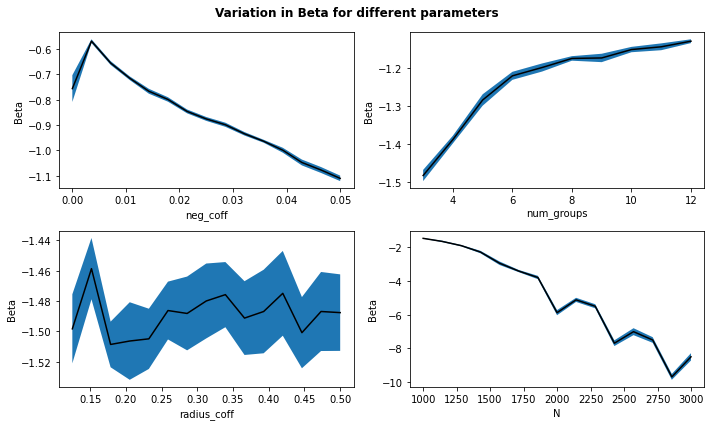

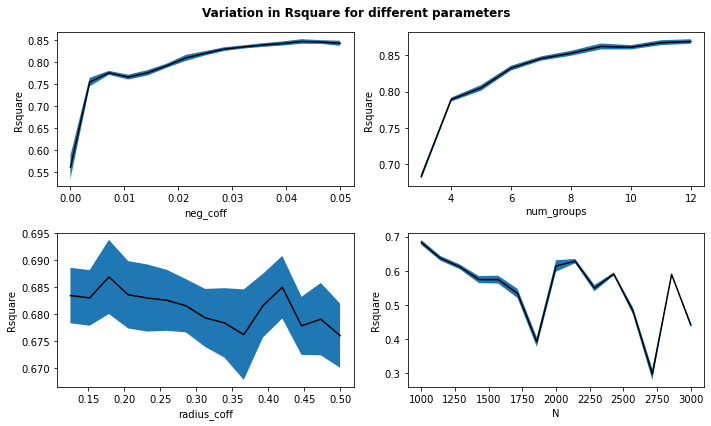

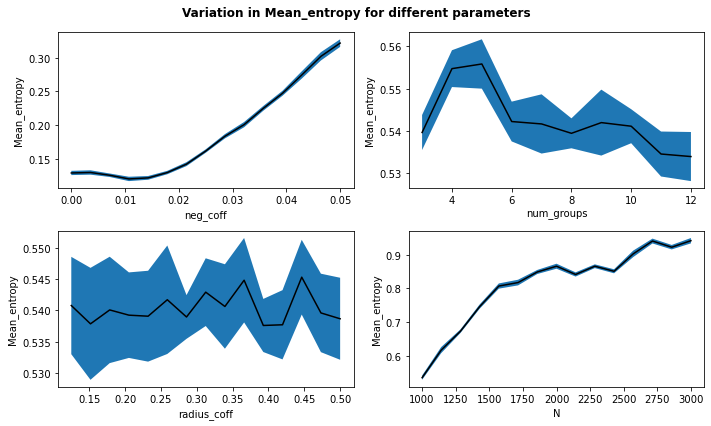

In [24]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(2,2, figsize=(10, 6))
    axs = axs.flatten()
    f.suptitle("Variation in {} for different parameters".format(param),fontweight='bold')
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], ofat_data[var], var, param, i)

for param in ('Beta','Rsquare','Mean_entropy'):
    plot_all_vars(param)
    plt.tight_layout()
    plt.show()

### SOBOL

In [25]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 10
max_steps = 30
distinct_samples = 8

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)


batch = BatchRunner(City_Model, 
                    max_steps =max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
sob_data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['neg_coff', 'num_groups', 'radius_coff', 'N'])
sob_data['Run'], sob_data['Beta'], sob_data['Rsquare'], sob_data['Mean_entropy'] = None, None, None, None

for i in range(replicates):
    for vals in param_values: 
        # Change parameters num_groups and N to integers
        vals = list(vals)
        vals[1] = int(vals[1])
        vals[3] = int(vals[3])
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count 
        sob_data.iloc[count, 0:4] = vals
        sob_data.iloc[count, 4:8] = iteration_data

        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [26]:
Si_beta = sobol.analyze(problem, sob_data['Beta'].values, print_to_console=True)
Si_rsquare = sobol.analyze(problem, sob_data['Rsquare'].values, print_to_console=True)
Si_mean_entropy = sobol.analyze(problem, sob_data['Mean_entropy'].values, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
neg_coff -0.042078 0.206928 0.697864 0.288545
num_groups 0.206368 0.292152 1.022778 0.265843
radius_coff 0.094880 0.315212 0.981683 0.270678
N -0.182731 0.283788 1.022877 0.238442

Parameter_1 Parameter_2 S2 S2_conf
neg_coff num_groups -0.245195 0.380434
neg_coff radius_coff 0.141786 0.413468
neg_coff N 0.955490 0.504005
num_groups radius_coff -0.143723 0.540860
num_groups N 0.209589 0.504560
radius_coff N 0.110094 0.487270
Parameter S1 S1_conf ST ST_conf
neg_coff -0.084895 0.255330 0.908555 0.358661
num_groups 0.038512 0.331235 1.297864 0.455790
radius_coff -0.065346 0.373456 1.108689 0.361179
N -0.282905 0.367893 1.134421 0.382817

Parameter_1 Parameter_2 S2 S2_conf
neg_coff num_groups -0.164639 0.563201
neg_coff radius_coff 0.213395 0.595152
neg_coff N 1.131464 0.816002
num_groups radius_coff 0.071695 0.506789
num_groups N 0.443609 0.545267
radius_coff N 0.273565 0.513266
Parameter S1 S1_conf ST ST_conf
neg_coff 0.107992 0.251370 0.678858 0.197690
num

In [27]:
def plot_index(ax, s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        ax: an axes to plot upon. 
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        
    l = len(indices)

    ax.set_title(title, fontsize=12)
    ax.set_ylim([-0.2, len(indices) - 1 + 0.2])
    ax.set_yticks(range(l))
    ax.set_yticklabels(params, fontsize=9, rotation=30) # labels
    ax.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    ax.axvline(0, c='k')

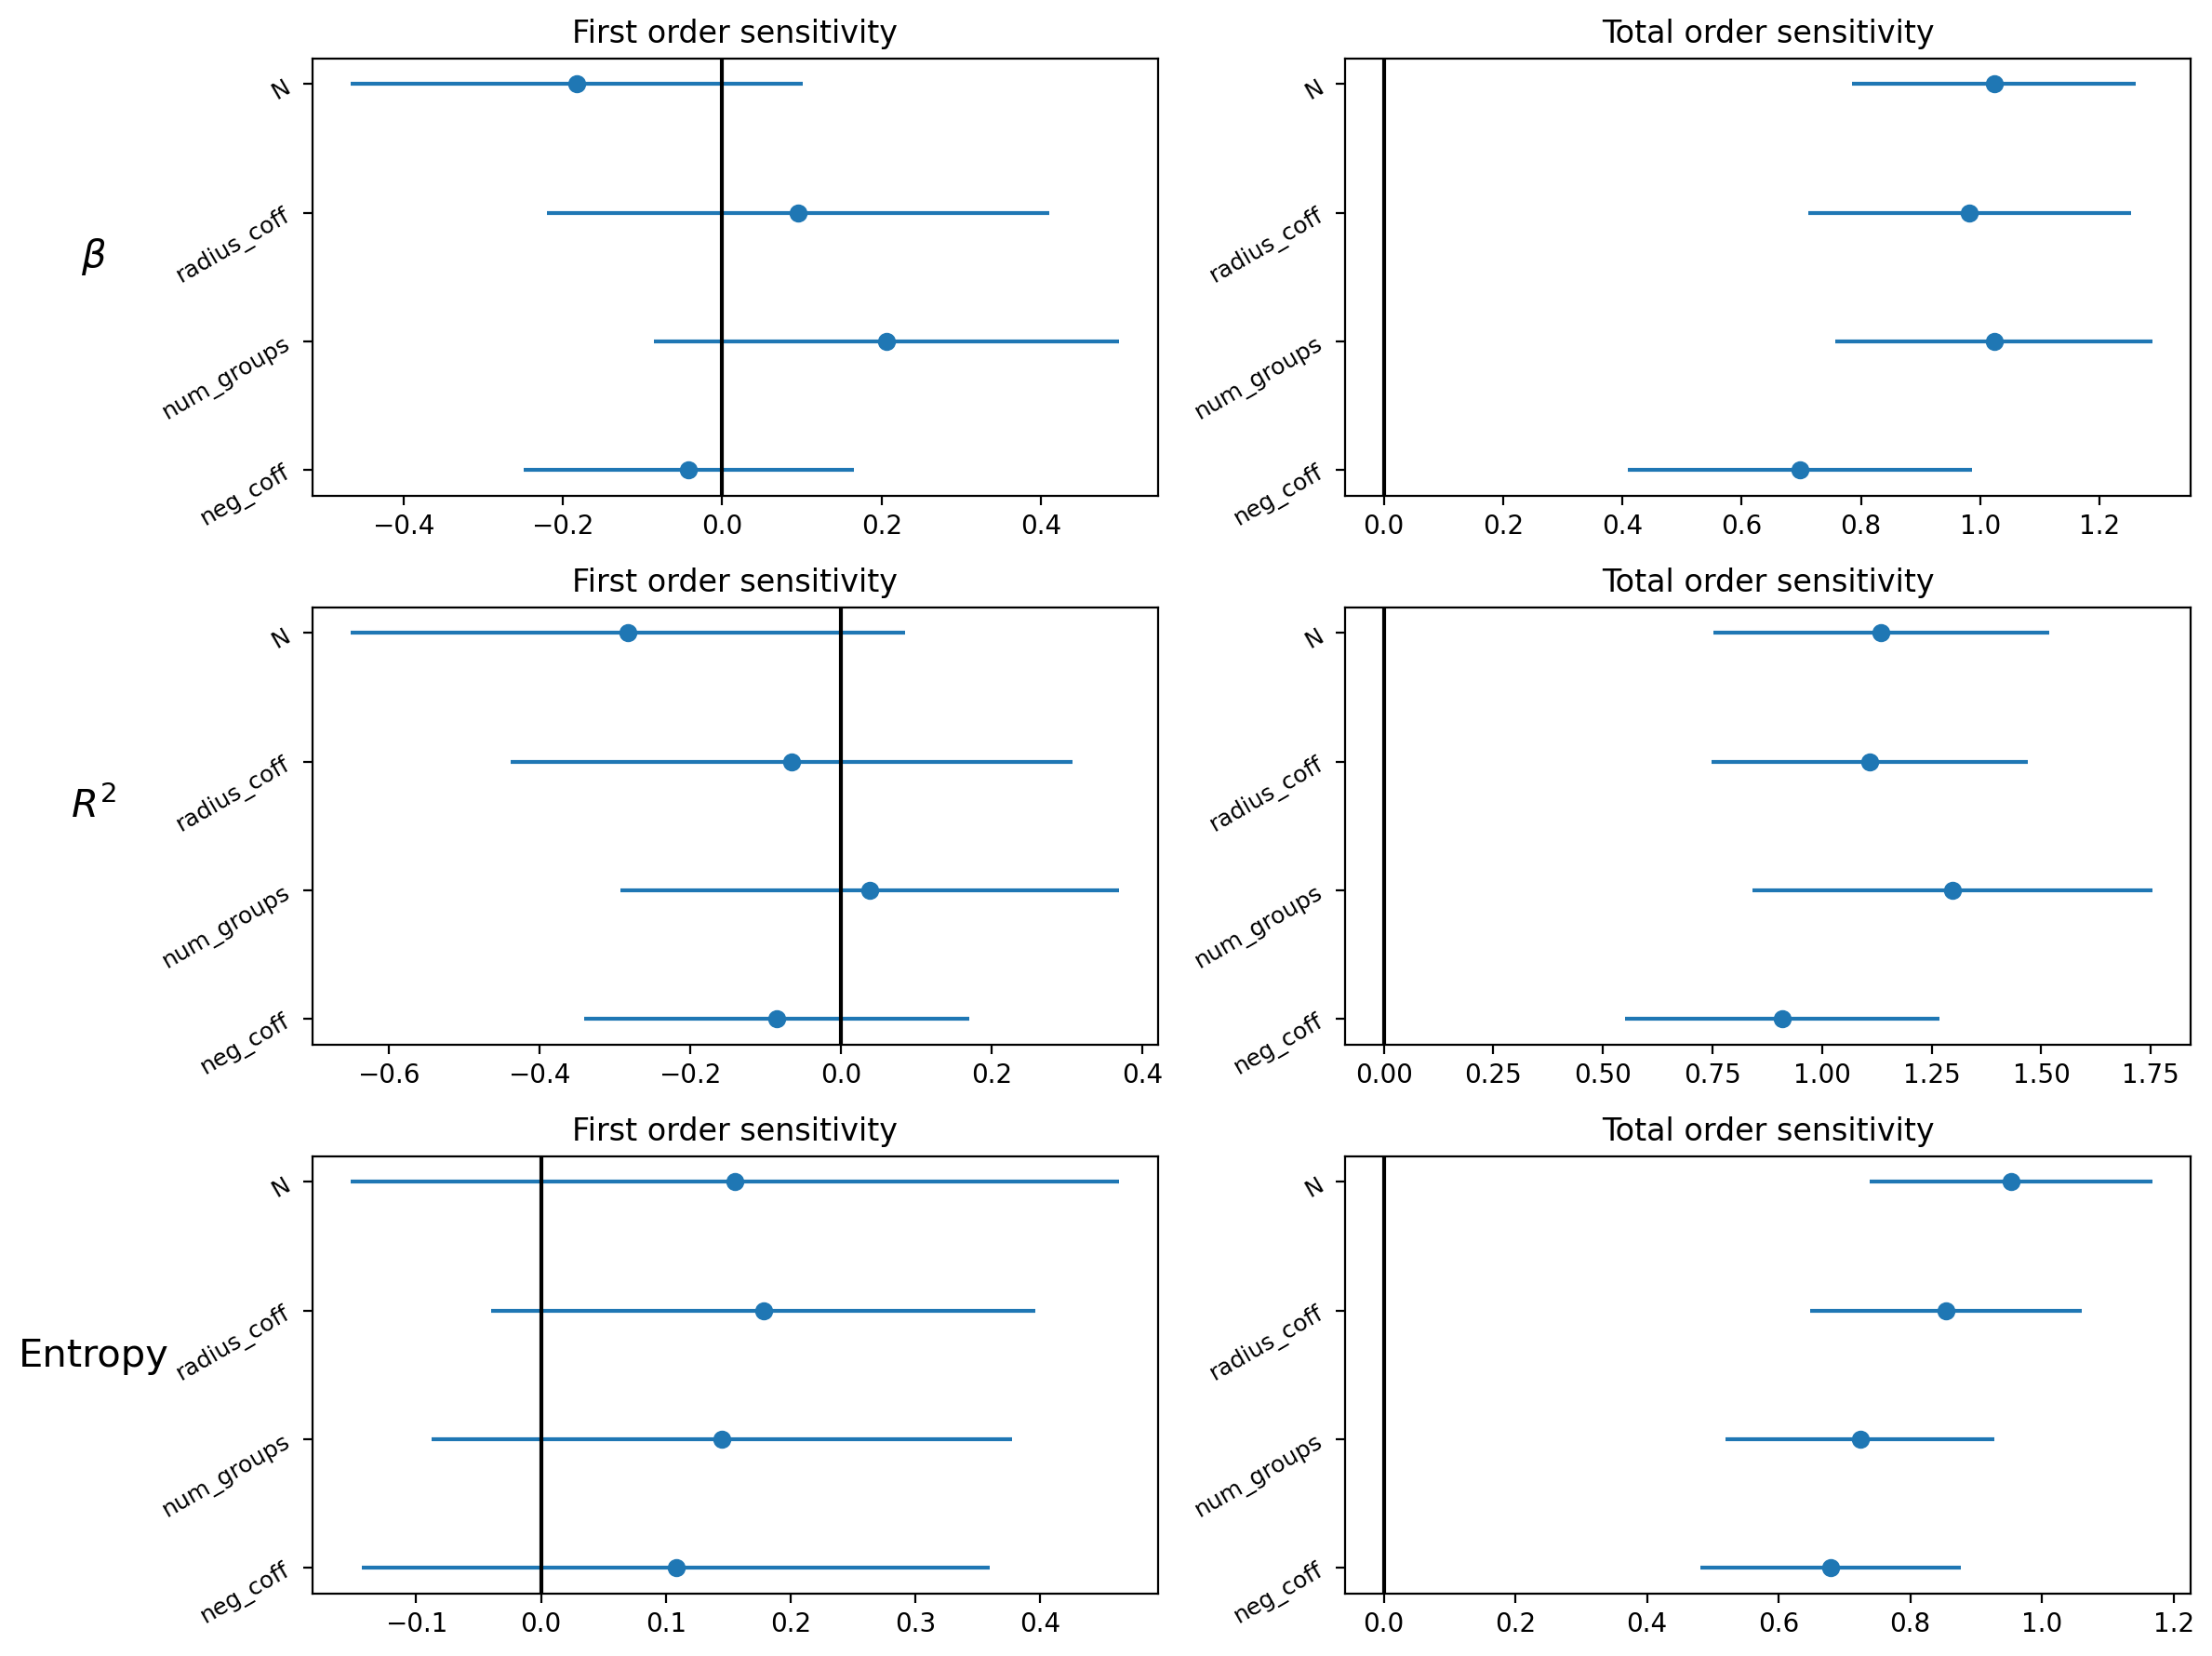

In [28]:
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(12,9),dpi=200)

axs = axs.flatten()
row_labels = [r'$\beta$',r'$R^2$','Entropy']
for i, Si in enumerate([Si_beta, Si_rsquare, Si_mean_entropy]):
    # First order
    plot_index(axs[2*i], Si, problem['names'], '1', 'First order sensitivity')
    axs[2*i].set_ylabel(row_labels[i], rotation=0, size=15)
    axs[2*i].yaxis.labelpad = 25
    

    '''
    # Second order
    plot_index(axs[3*i+1], Si, problem['names'], '2', 'Second order sensitivity')
    #plt.show()'''

    # Total order
    plot_index(axs[2*i+1], Si, problem['names'], 'T', 'Total order sensitivity')
    
    
plt.tight_layout() 